# Task 1 : Analyse des Dépendances Fonctionnelles (FDs)

## Objectif
Comprendre ce que produit un algorithme de découverte de FDs **avant** de raisonner sur leur signification.

## Ce qu'on doit faire :
1. Lire les fichiers FD fournis
2. Calculer :
   - Nombre de FDs
   - Taille moyenne du LHS (côté gauche)
   - Fréquence des attributs (comme LHS et RHS)
3. Identifier :
   - FDs basées sur des IDs
   - FDs avec des déterminants très larges
   - FDs suspectes

In [1]:
# Imports nécessaires
import os
import json
import pandas as pd
import numpy as np
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration pour de beaux graphiques
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

print("Bibliothèques chargées avec succès !")


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.3.5 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "c:\Users\USER\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "C:\Users\USER\AppData\Roaming\Python\Python312\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "c:\Users\USER\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 701, in start
    self.io_loop.start()
  File "C:\Users\USER\AppData\

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.3.5 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "c:\Users\USER\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "C:\Users\USER\AppData\Roaming\Python\Python312\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "c:\Users\USER\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 701, in start
    self.io_loop.start()
  File "C:\Users\USER\AppData\

ImportError: 
A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.3.5 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.



Bibliothèques chargées avec succès !


In [2]:
# Définir les chemins
BASE_PATH = os.path.dirname(os.getcwd())  # Dossier parent du notebook
FDS_PATH = os.path.join(BASE_PATH, 'Valid_FDS')
DATASETS_PATH = os.path.join(BASE_PATH, 'Datasets')

print(f"Chemin des FDs: {FDS_PATH}")
print(f"Chemin des datasets: {DATASETS_PATH}")

# Lister les fichiers FD disponibles
fd_files = [f for f in os.listdir(FDS_PATH) if not f.startswith('.') and '_fds' in f]
print(f"\nFichiers FD trouvés: {fd_files}")

Chemin des FDs: c:\Users\USER\Desktop\M2IASD\S2\qualite de donne\Projet_Data_Quality\Valid_FDS
Chemin des datasets: c:\Users\USER\Desktop\M2IASD\S2\qualite de donne\Projet_Data_Quality\Datasets

Fichiers FD trouvés: ['abalone_fds', 'adult_fds', 'balance-scale_fds', 'breast-cancer-wisconsin_fds', 'bridges_fds', 'chess_fds', 'echocardiogram_fds', 'hepatitis_fds', 'horse_fds', 'iris_fds', 'nursery_fds']


## 1. Parser les fichiers FD

Les fichiers FD ont deux formats différents :
1. **Format simple** : `3,2,1->5` (iris, abalone, etc.)
2. **Format JSON** : objets JSON par ligne (bridges)

On va créer des fonctions pour parser les deux formats.

In [3]:
def parse_simple_format(filepath):
    """
    Parse le format simple des FDs.
    Format: 3,2,1->5 signifie que les colonnes 3,2,1 déterminent la colonne 5
    
    Retourne:
    - fds: liste de tuples (lhs, rhs) où lhs est un tuple et rhs est un string
    - column_mapping: dictionnaire de mapping des colonnes
    """
    fds = []
    column_mapping = {}
    in_results = False
    
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            
            if line == '# RESULTS':
                in_results = True
                continue
            
            if line.startswith('# COLUMN'):
                continue
            
            if line.startswith('# TABLES'):
                continue
            
            # Parser le mapping des colonnes (format: 1.nom_colonne  index)
            if not in_results and '\t' in line and not line.startswith('#'):
                parts = line.split('\t')
                if len(parts) == 2:
                    col_name = parts[0].split('.', 1)[1] if '.' in parts[0] else parts[0]
                    col_index = parts[1]
                    column_mapping[col_index] = col_name
            
            # Parser les FDs (format: 3,2,1->5)
            if in_results and '->' in line:
                lhs_str, rhs = line.split('->')
                lhs = tuple(lhs_str.split(','))
                fds.append((lhs, rhs))
    
    return fds, column_mapping


def parse_json_format(filepath):
    """
    Parse le format JSON des FDs (comme bridges_fds).
    Chaque ligne est un objet JSON décrivant une FD.
    
    Retourne:
    - fds: liste de tuples (lhs, rhs)
    - column_mapping: dictionnaire vide (les noms sont déjà dans le JSON)
    """
    fds = []
    
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            
            try:
                obj = json.loads(line)
                if obj.get('type') == 'FunctionalDependency':
                    # Extraire le LHS (determinant)
                    lhs_cols = obj['determinant']['columnIdentifiers']
                    lhs = tuple(col['columnIdentifier'] for col in lhs_cols)
                    
                    # Extraire le RHS (dependant)
                    rhs = obj['dependant']['columnIdentifier']
                    
                    fds.append((lhs, rhs))
            except json.JSONDecodeError:
                continue
    
    return fds, {}


def parse_fd_file(filepath):
    """
    Détecte automatiquement le format et parse le fichier FD.
    """
    with open(filepath, 'r', encoding='utf-8') as f:
        first_line = f.readline().strip()
    
    # Si la première ligne commence par '{', c'est du JSON
    if first_line.startswith('{'):
        return parse_json_format(filepath)
    else:
        return parse_simple_format(filepath)

print("Fonctions de parsing définies !")

Fonctions de parsing définies !


In [4]:
# Charger tous les fichiers FD
all_fds = {}
all_mappings = {}

for fd_file in fd_files:
    filepath = os.path.join(FDS_PATH, fd_file)
    dataset_name = fd_file.replace('_fds', '')
    
    fds, mapping = parse_fd_file(filepath)
    
    if fds:  # Seulement si on a des FDs
        all_fds[dataset_name] = fds
        all_mappings[dataset_name] = mapping
        print(f"{dataset_name}: {len(fds)} FDs trouvées")
    else:
        print(f"{dataset_name}: VIDE (pas de FDs)")

print(f"\nTotal: {len(all_fds)} datasets avec des FDs")

abalone: 137 FDs trouvées
adult: VIDE (pas de FDs)
balance-scale: 1 FDs trouvées
breast-cancer-wisconsin: 46 FDs trouvées
bridges: 144 FDs trouvées
chess: 1 FDs trouvées
echocardiogram: 527 FDs trouvées
hepatitis: 8296 FDs trouvées
horse: VIDE (pas de FDs)
iris: 4 FDs trouvées
nursery: 1 FDs trouvées

Total: 9 datasets avec des FDs


## 2. Calculer les statistiques pour chaque dataset

Pour chaque dataset, on calcule :
- **Nombre de FDs** : combien de dépendances fonctionnelles ont été découvertes
- **Taille moyenne du LHS** : en moyenne, combien d'attributs sont nécessaires pour déterminer un autre
- **Fréquence des attributs** : quels attributs apparaissent le plus souvent comme déterminants (LHS) ou déterminés (RHS)

In [5]:
def analyze_fds(fds, dataset_name):
    """
    Analyse un ensemble de FDs et retourne des statistiques.
    """
    if not fds:
        return None
    
    # Nombre de FDs
    num_fds = len(fds)
    
    # Taille du LHS
    lhs_sizes = [len(fd[0]) for fd in fds]
    avg_lhs_size = np.mean(lhs_sizes)
    min_lhs_size = min(lhs_sizes)
    max_lhs_size = max(lhs_sizes)
    
    # Fréquence des attributs comme LHS
    lhs_counter = Counter()
    for fd in fds:
        for attr in fd[0]:
            lhs_counter[attr] += 1
    
    # Fréquence des attributs comme RHS
    rhs_counter = Counter()
    for fd in fds:
        rhs_counter[fd[1]] += 1
    
    # FDs avec LHS de taille 1 (potentiellement des clés)
    single_attr_fds = [fd for fd in fds if len(fd[0]) == 1]
    
    # FDs avec grand LHS (potentiellement sur-ajustées)
    large_lhs_fds = [fd for fd in fds if len(fd[0]) >= 4]
    
    return {
        'dataset': dataset_name,
        'num_fds': num_fds,
        'avg_lhs_size': round(avg_lhs_size, 2),
        'min_lhs_size': min_lhs_size,
        'max_lhs_size': max_lhs_size,
        'lhs_frequency': lhs_counter,
        'rhs_frequency': rhs_counter,
        'single_attr_fds': single_attr_fds,
        'large_lhs_fds': large_lhs_fds,
        'all_fds': fds
    }

# Analyser tous les datasets
analyses = {}
for dataset_name, fds in all_fds.items():
    analysis = analyze_fds(fds, dataset_name)
    if analysis:
        analyses[dataset_name] = analysis

print("Analyses terminées pour tous les datasets !")

Analyses terminées pour tous les datasets !


In [6]:
# Créer un tableau récapitulatif
summary_data = []
for name, analysis in analyses.items():
    summary_data.append({
        'Dataset': name,
        'Nombre de FDs': analysis['num_fds'],
        'Taille moy. LHS': analysis['avg_lhs_size'],
        'Min LHS': analysis['min_lhs_size'],
        'Max LHS': analysis['max_lhs_size'],
        'FDs à 1 attribut': len(analysis['single_attr_fds']),
        'FDs larges (≥4)': len(analysis['large_lhs_fds'])
    })

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values('Nombre de FDs', ascending=False)
print("\n" + "="*80)
print("TABLEAU RÉCAPITULATIF DES FDs PAR DATASET")
print("="*80)
display(summary_df)


TABLEAU RÉCAPITULATIF DES FDs PAR DATASET


,Dataset,Nombre de FDs,Taille moy. LHS,Min LHS,Max LHS,FDs à 1 attribut,FDs larges (≥4)
6,hepatitis,8296,3.76,2,6,0,5229
5,echocardiogram,527,3.22,1,4,2,160
3,bridges,144,3.69,1,6,13,87
0,abalone,137,4.22,3,6,0,119
2,breast-cancer-wisconsin,46,2.70,1,4,1,5
7,iris,4,3.00,3,3,0,0
1,balance-scale,1,1.00,1,1,1,0
4,chess,1,6.00,6,6,0,1
8,nursery,1,7.00,7,7,0,1


## 3. Analyse détaillée par dataset

Maintenant on va analyser chaque dataset en détail pour identifier :
- Les **FDs basées sur des IDs** (un seul attribut qui détermine tout)
- Les **FDs suspectes** (grands LHS, patterns étranges)
- La **distribution des attributs** dans les FDs

In [7]:
def display_detailed_analysis(analysis, mapping=None):
    """
    Affiche une analyse détaillée d'un dataset.
    """
    print(f"\n{'='*60}")
    print(f"DATASET: {analysis['dataset'].upper()}")
    print(f"{'='*60}")
    
    print(f"\n STATISTIQUES GÉNÉRALES:")
    print(f"   - Nombre total de FDs: {analysis['num_fds']}")
    print(f"   - Taille moyenne du LHS: {analysis['avg_lhs_size']}")
    print(f"   - Taille min/max du LHS: {analysis['min_lhs_size']} / {analysis['max_lhs_size']}")
    
    print(f"\n FRÉQUENCE DES ATTRIBUTS COMME LHS (top 5):")
    for attr, count in analysis['lhs_frequency'].most_common(5):
        attr_name = mapping.get(attr, attr) if mapping else attr
        print(f"   - {attr_name}: {count} fois")
    
    print(f"\nFRÉQUENCE DES ATTRIBUTS COMME RHS (top 5):")
    for attr, count in analysis['rhs_frequency'].most_common(5):
        attr_name = mapping.get(attr, attr) if mapping else attr
        print(f"   - {attr_name}: {count} fois")
    
    # FDs potentiellement basées sur des IDs
    if analysis['single_attr_fds']:
        print(f"\n FDs À UN SEUL ATTRIBUT (potentielles clés/IDs):")
        for fd in analysis['single_attr_fds'][:5]:  # Limiter à 5
            lhs_name = mapping.get(fd[0][0], fd[0][0]) if mapping else fd[0][0]
            rhs_name = mapping.get(fd[1], fd[1]) if mapping else fd[1]
            print(f"   - {lhs_name} → {rhs_name}")
        if len(analysis['single_attr_fds']) > 5:
            print(f"   ... et {len(analysis['single_attr_fds']) - 5} autres")
    
    # FDs avec grand LHS
    if analysis['large_lhs_fds']:
        print(f"\n FDs AVEC GRAND LHS (≥4 attributs) - potentiellement sur-ajustées:")
        for fd in analysis['large_lhs_fds'][:3]:  # Limiter à 3
            lhs_names = [mapping.get(a, a) if mapping else a for a in fd[0]]
            rhs_name = mapping.get(fd[1], fd[1]) if mapping else fd[1]
            print(f"   - {', '.join(lhs_names)} → {rhs_name}")
        if len(analysis['large_lhs_fds']) > 3:
            print(f"   ... et {len(analysis['large_lhs_fds']) - 3} autres")

# Afficher l'analyse détaillée pour chaque dataset
for name, analysis in analyses.items():
    mapping = all_mappings.get(name, {})
    display_detailed_analysis(analysis, mapping)


DATASET: ABALONE

📊 STATISTIQUES GÉNÉRALES:
   - Nombre total de FDs: 137
   - Taille moyenne du LHS: 4.22
   - Taille min/max du LHS: 3 / 6

📈 FRÉQUENCE DES ATTRIBUTS COMME LHS (top 5):
   - 0.101: 84 fois
   - 0.514: 79 fois
   - 0.2245: 77 fois
   - 0.455: 71 fois
   - 15: 64 fois

📉 FRÉQUENCE DES ATTRIBUTS COMME RHS (top 5):
   - M: 25 fois
   - 0.15: 21 fois
   - 0.365: 17 fois
   - 0.095: 14 fois
   - 0.455: 13 fois

🔍 FDs AVEC GRAND LHS (≥4 attributs) - potentiellement sur-ajustées:
   - 0.2245, 0.455, 0.514, M → 0.365
   - 0.2245, 0.455, 0.514, M → 0.095
   - 0.2245, 0.455, 0.514, M → 0.101
   ... et 116 autres

DATASET: BALANCE-SCALE

📊 STATISTIQUES GÉNÉRALES:
   - Nombre total de FDs: 1
   - Taille moyenne du LHS: 1.0
   - Taille min/max du LHS: 1 / 1

📈 FRÉQUENCE DES ATTRIBUTS COMME LHS (top 5):
   - 1: 1 fois

📉 FRÉQUENCE DES ATTRIBUTS COMME RHS (top 5):
   - B: 1 fois

⚠️  FDs À UN SEUL ATTRIBUT (potentielles clés/IDs):
   - 1 → B

DATASET: BREAST-CANCER-WISCONSIN

📊 STAT

## 4. Visualisations

Créons des graphiques pour mieux comprendre la distribution des FDs.

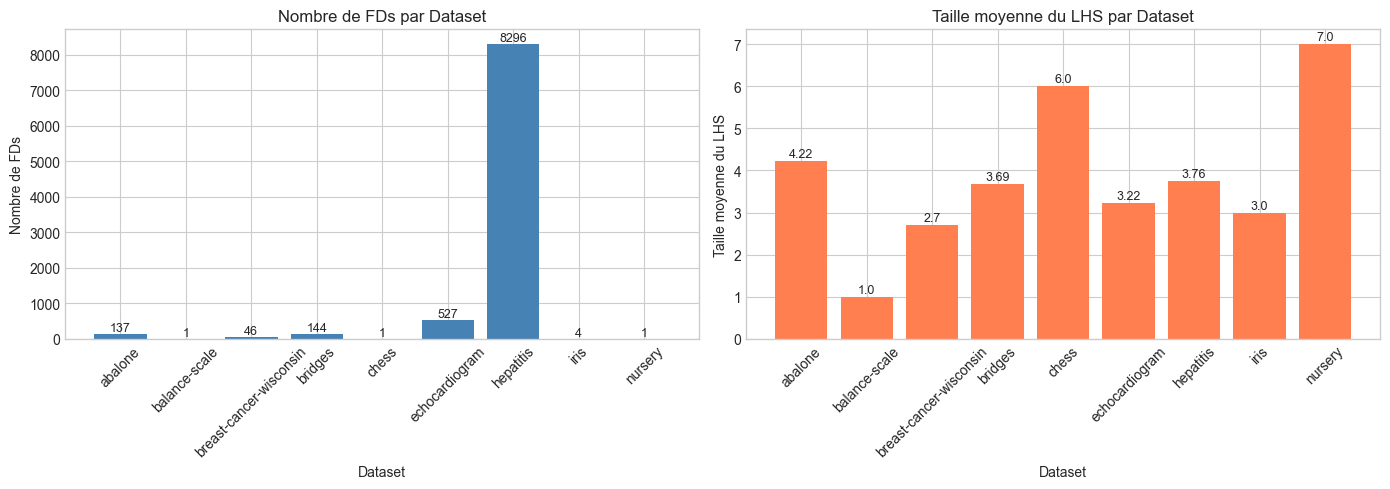

Graphique sauvegardé dans results/task1_fd_statistics.png


In [8]:
# Graphique 1: Nombre de FDs par dataset
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart du nombre de FDs
datasets = list(analyses.keys())
num_fds = [analyses[d]['num_fds'] for d in datasets]

ax1 = axes[0]
bars = ax1.bar(datasets, num_fds, color='steelblue')
ax1.set_xlabel('Dataset')
ax1.set_ylabel('Nombre de FDs')
ax1.set_title('Nombre de FDs par Dataset')
ax1.tick_params(axis='x', rotation=45)

# Ajouter les valeurs sur les barres
for bar, val in zip(bars, num_fds):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
             str(val), ha='center', va='bottom', fontsize=9)

# Bar chart de la taille moyenne du LHS
avg_lhs = [analyses[d]['avg_lhs_size'] for d in datasets]

ax2 = axes[1]
bars2 = ax2.bar(datasets, avg_lhs, color='coral')
ax2.set_xlabel('Dataset')
ax2.set_ylabel('Taille moyenne du LHS')
ax2.set_title('Taille moyenne du LHS par Dataset')
ax2.tick_params(axis='x', rotation=45)

for bar, val in zip(bars2, avg_lhs):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
             str(val), ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('../results/task1_fd_statistics.png', dpi=150, bbox_inches='tight')
plt.show()
print("Graphique sauvegardé dans results/task1_fd_statistics.png")

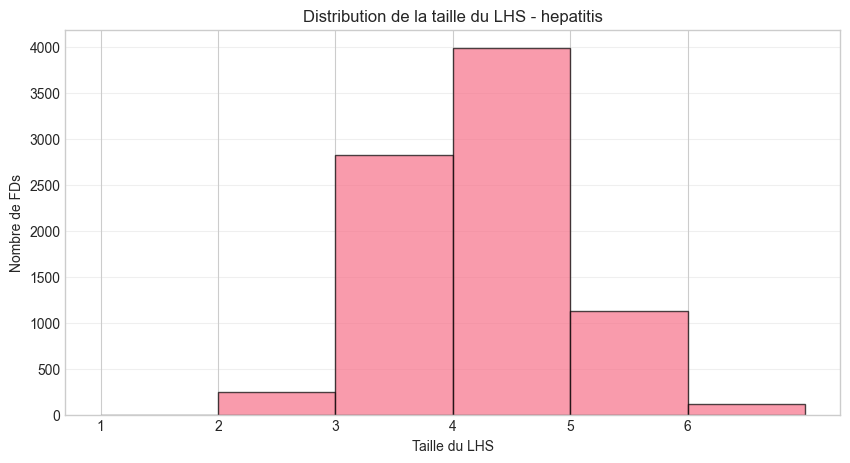

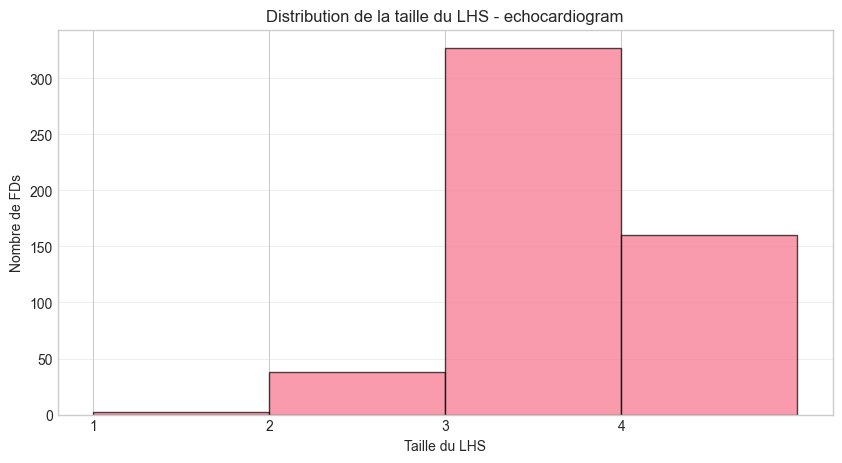

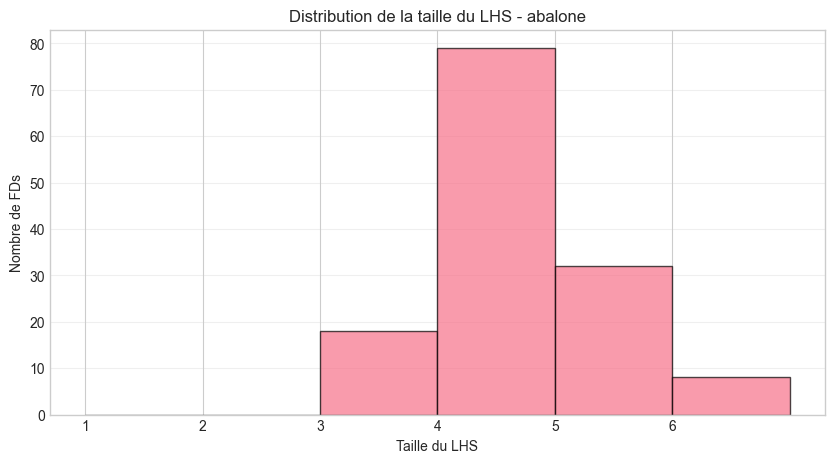

In [9]:
# Graphique 2: Distribution de la taille du LHS pour un dataset spécifique
def plot_lhs_distribution(analysis):
    """
    Affiche la distribution des tailles de LHS pour un dataset.
    """
    lhs_sizes = [len(fd[0]) for fd in analysis['all_fds']]
    
    plt.figure(figsize=(10, 5))
    plt.hist(lhs_sizes, bins=range(1, max(lhs_sizes)+2), edgecolor='black', alpha=0.7)
    plt.xlabel('Taille du LHS')
    plt.ylabel('Nombre de FDs')
    plt.title(f"Distribution de la taille du LHS - {analysis['dataset']}")
    plt.xticks(range(1, max(lhs_sizes)+1))
    plt.grid(axis='y', alpha=0.3)
    plt.show()

# Afficher pour les datasets avec beaucoup de FDs
for name in ['hepatitis', 'echocardiogram', 'abalone']:
    if name in analyses:
        plot_lhs_distribution(analyses[name])

## 5. Identification des FDs suspectes

On va maintenant identifier les types de FDs potentiellement problématiques :

1. **FDs dégénérées** : un ID détermine tout (ex: StudentID → Email)
2. **FDs sur-ajustées** : trop d'attributs dans le LHS
3. **FDs triviales** : attributs très corrélés ou redondants

In [10]:
def identify_suspicious_fds(analysis, mapping=None):
    """
    Identifie les FDs suspectes dans un dataset.
    """
    suspicious = {
        'degenerate': [],      # FDs basées sur des IDs
        'overfitted': [],      # FDs avec LHS trop grand
        'key_candidates': []   # Attributs qui déterminent beaucoup de choses
    }
    
    # Trouver les attributs qui déterminent beaucoup de RHS (potentiels IDs)
    lhs_to_rhs = defaultdict(set)
    for fd in analysis['all_fds']:
        if len(fd[0]) == 1:  # LHS à un seul attribut
            lhs_to_rhs[fd[0][0]].add(fd[1])
    
    # Si un attribut détermine plus de 3 autres attributs, c'est suspect
    for attr, rhs_set in lhs_to_rhs.items():
        if len(rhs_set) >= 3:
            attr_name = mapping.get(attr, attr) if mapping else attr
            suspicious['key_candidates'].append({
                'attribute': attr_name,
                'determines': len(rhs_set),
                'rhs_list': list(rhs_set)
            })
    
    # FDs sur-ajustées (LHS >= 5)
    for fd in analysis['all_fds']:
        if len(fd[0]) >= 5:
            lhs_names = [mapping.get(a, a) if mapping else a for a in fd[0]]
            rhs_name = mapping.get(fd[1], fd[1]) if mapping else fd[1]
            suspicious['overfitted'].append({
                'lhs': lhs_names,
                'rhs': rhs_name,
                'lhs_size': len(fd[0])
            })
    
    return suspicious

# Analyser les FDs suspectes pour chaque dataset
print("\n" + "="*80)
print("ANALYSE DES FDs SUSPECTES")
print("="*80)

for name, analysis in analyses.items():
    mapping = all_mappings.get(name, {})
    suspicious = identify_suspicious_fds(analysis, mapping)
    
    print(f"\n {name.upper()}:")
    
    if suspicious['key_candidates']:
        print(f"    Candidats clés (déterminent ≥3 attributs):")
        for kc in suspicious['key_candidates']:
            print(f"      - {kc['attribute']} → {kc['determines']} attributs")
    else:
        print(f"    Pas de candidat clé évident")
    
    if suspicious['overfitted']:
        print(f"     FDs sur-ajustées (LHS ≥ 5): {len(suspicious['overfitted'])}")
    else:
        print(f"    Pas de FDs sur-ajustées")


ANALYSE DES FDs SUSPECTES

📋 ABALONE:
   🔑 Pas de candidat clé évident
   ⚠️  FDs sur-ajustées (LHS ≥ 5): 40

📋 BALANCE-SCALE:
   🔑 Pas de candidat clé évident
   ✅ Pas de FDs sur-ajustées

📋 BREAST-CANCER-WISCONSIN:
   🔑 Pas de candidat clé évident
   ✅ Pas de FDs sur-ajustées

📋 BRIDGES:
   🔑 Candidats clés (déterminent ≥3 attributs):
      - E1 → 11 attributs
   ⚠️  FDs sur-ajustées (LHS ≥ 5): 43

📋 CHESS:
   🔑 Pas de candidat clé évident
   ⚠️  FDs sur-ajustées (LHS ≥ 5): 1

📋 ECHOCARDIOGRAM:
   🔑 Pas de candidat clé évident
   ✅ Pas de FDs sur-ajustées

📋 HEPATITIS:
   🔑 Pas de candidat clé évident
   ⚠️  FDs sur-ajustées (LHS ≥ 5): 1244

📋 IRIS:
   🔑 Pas de candidat clé évident
   ✅ Pas de FDs sur-ajustées

📋 NURSERY:
   🔑 Pas de candidat clé évident
   ⚠️  FDs sur-ajustées (LHS ≥ 5): 1


## 6. Sauvegarder les résultats

On sauvegarde les résultats de l'analyse pour les utiliser dans les tâches suivantes.

In [11]:
# Sauvegarder le tableau récapitulatif en CSV
summary_df.to_csv('../results/task1_summary.csv', index=False)
print("Tableau récapitulatif sauvegardé dans results/task1_summary.csv")

# Sauvegarder les FDs parsées en JSON pour usage ultérieur
import json

fds_export = {}
for name, fds in all_fds.items():
    fds_export[name] = [
        {'lhs': list(fd[0]), 'rhs': fd[1]} 
        for fd in fds
    ]

with open('../results/task1_all_fds.json', 'w', encoding='utf-8') as f:
    json.dump(fds_export, f, indent=2)
print("FDs parsées sauvegardées dans results/task1_all_fds.json")

Tableau récapitulatif sauvegardé dans results/task1_summary.csv
FDs parsées sauvegardées dans results/task1_all_fds.json
